# Recursive Deep Learning Framework
### There are three different strategies

### Imports

In [113]:
import pandas as pd
import numpy as np
import pickle
import os
import gc
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

warnings.filterwarnings("ignore")

In [114]:
### Configuration
TARGET_VARIABLES = ['co2', 'gdp', 'primary_energy_consumption']
N_STEPS_IN = 5
N_STEPS_OUT = 3
VAL_SIZE = 0.15
TEST_SIZE = 0.15

G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

FEATURES = [
    'fossil_fuel_consumption', 'energy_per_capita',
    'electricity_generation', 'population',
    'nuclear_consumption', 'renewables_consumption'
]

### Utility Functions

In [115]:
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()

In [116]:
def rmse(y_pred, y_actual):
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [117]:
def mase(y_actual, y_pred, period=1):

    mae_forecast = mean_absolute_error(y_actual, y_pred)
    
    # MAE of naive forecast
    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]
    
    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)
    
    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

### Data Load

In [118]:
def load_data(save_dir='data_export'):
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')
    lag_df = pd.read_pickle(lag_path)
    print(f"Data Shape: {lag_df.shape}")
    return lag_df

### Model builds

In [119]:
def build_lstm(input_shape, output_shape, hidden=32):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [120]:
def build_bilstm(input_shape, output_shape, hidden=16):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01)),
                      input_shape=input_shape),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [121]:
def build_edlstm(input_shape, output_shape, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        RepeatVector(output_shape),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [122]:
def build_cnn(input_shape, output_shape, filters=32, hidden=16):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(hidden, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

### Data Preparation

In [123]:
def prep_seq(data, features, target, input_steps=N_STEPS_IN, output_steps=N_STEPS_OUT):

    feature_cols = []
    for feature in features:
        if feature not in data.columns:
            continue
        feature_cols.append(feature)

        for lag in range(1, 5):
            lag_col = f"{feature}_lag{lag}"
            if lag_col in data.columns:
                feature_cols.append(lag_col)

    all_cols = feature_cols + [target, 'year']
    data_subset = data[all_cols].dropna()

    print(f"Number of feature columns: {len(feature_cols)}")
    print(f"Feature columns ex 5: {feature_cols[:5]}")

    X = data_subset[feature_cols].values
    y = data_subset[target].values
    years = data_subset['year'].values

    print(f"X shape: {X.shape}, y shape: {y.shape}")

    return X, y, years

### The MultiStepForecast class has three different experiments
1. Sliding window by 3 steps
2. Sliding window by each step
3. Recursive strategy sliding window by steps

In [ ]:
class MultiStepForecast:
    def __init__(self, model_func, input_steps=N_STEPS_IN, output_steps=N_STEPS_OUT):
        self.model_func = model_func
        self.input_steps = input_steps
        self.output_steps = output_steps
        self.model = None
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        # Error correction parameter
        self.error_correction_alpha = 0.5

    def create_sequences(self, X, y, input_steps, output_steps):
        X_seq = []
        y_seq = []
        
        for i in range(len(X) - input_steps - output_steps + 1):
            X_seq.append(X[i:i+input_steps])
            y_seq.append(y[i+input_steps:i+input_steps+output_steps])
        
        return np.array(X_seq), np.array(y_seq)

    def train_model(self, X_full, y_full, X_train, y_train, X_val, y_val):
        # Scaler
        self.X_scaler.fit(X_full)
        self.y_scaler.fit(y_full.reshape(-1, 1))
        
        # Scaling
        X_train_scaled = self.X_scaler.fit_transform(X_train)
        y_train_scaled = self.y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
        
        # Create sequences
        X_train_seq, y_train_seq = self.create_sequences(X_train_scaled, y_train_scaled, self.input_steps, self.output_steps)
    
        # Handle None validation data
        validation_data = None
        if X_val is not None and len(X_val) >= self.input_steps + self.output_steps:
            X_val_scaled = self.X_scaler.transform(X_val)
            y_val_scaled = self.y_scaler.transform(y_val.reshape(-1, 1)).ravel()

            X_val_seq, y_val_seq = self.create_sequences(X_val_scaled, y_val_scaled, self.input_steps, self.output_steps)
            if len(X_val_seq) > 0:
                validation_data = (X_val_seq, y_val_seq)

        # Build model
        input_shape = (self.input_steps, X_train_scaled.shape[1])
        
        if self.model_func == build_edlstm:
            self.model = self.model_func(input_shape, self.output_steps)
            y_train_seq = y_train_seq.reshape(y_train_seq.shape[0], y_train_seq.shape[1], 1)

            if validation_data:
                y_val_seq = validation_data[1].reshape(validation_data[1].shape[0], validation_data[1].shape[1], 1)
                validation_data = (validation_data[0], y_val_seq)
        else:
            self.model = self.model_func(input_shape, self.output_steps)
        
        self.model.summary()

        callbacks = []
        if validation_data:
            early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            callbacks.append(early_stopping)

        self.model.summary()

        self.model.fit(
            X_train_seq, y_train_seq,
            validation_data=validation_data,
            epochs=100,
            batch_size=min(32, len(X_train_seq)),
            callbacks=callbacks,
            verbose=0
        )

    def experiment_1(self, X_full, y_full):
        print(f"\nFirst Experiment: Sliding window by 3 steps (no overlapping)")

        X_scaled = self.X_scaler.transform(X_full)
        results = []
        
        position = 0
        iteration = 0

        max_position = len(X_full) - self.input_steps
        
        while position <= max_position:
            actual_end = position + self.input_steps + self.output_steps
            if actual_end > len(y_full):
                # Cannot compare full pred, but still make partial pred
                actual_end = len(y_full)

                if position + self.input_steps >= len(y_full):
                    break

            X_input = X_scaled[position:position + self.input_steps]
            X_input = X_input.reshape(1, self.input_steps, -1)
            
            # Preds
            y_pred_scaled = self.model.predict(X_input, verbose=0)
            if len(y_pred_scaled.shape) == 3:
                y_pred_scaled = y_pred_scaled.reshape(1, -1)
            y_pred = self.y_scaler.inverse_transform(y_pred_scaled).ravel()
            
            # Actuals
            actual_start = position + self.input_steps
            y_actual = y_full[actual_start:actual_end]

            # Adjusting pred length with actual
            y_pred = y_pred[:len(y_actual)]
            
            if len(y_actual) > 0:
                # Metrics
                rmse_val = rmse(y_pred, y_actual)
                mase_val = mase(y_actual, y_pred)
                
                result = {
                    'iteration': iteration,
                    'input_range': (position, position + self.input_steps),
                    'predict_range': (actual_start, actual_end),
                    'predictions': y_pred,
                    'actuals': y_actual,
                    'errors': y_pred - y_actual,
                    'rmse': rmse_val,
                    'mase': mase_val
                }
                
                results.append(result)
                print(f"Iteration {iteration}: RMSE: {rmse_val:.4f}")
            
            # Move forward by output_steps
            position += self.output_steps
            iteration += 1

        print(f"Total iterations: {len(results)}")
        return results
    
    def experiment_2(self, X_full, y_full):
        print(f"\nSecond Experiment: Sliding window by each step")

        X_full_scaled = self.X_scaler.transform(X_full)
        results = []
        
        position = 0
        iteration = 0

        max_position = len(X_full) - self.input_steps
        
        # Iterate through all possible positions
        while position <= max_position:
            actual_end = position + self.input_steps + self.output_steps

            if actual_end > len(y_full):
                actual_end = len(y_full)
                
                if position + self.input_steps >= len(y_full):
                    break

            X_input = X_full_scaled[position:position + self.input_steps]
            X_input = X_input.reshape(1, self.input_steps, -1)
            
            # Pred
            y_pred_scaled = self.model.predict(X_input, verbose=0)

            if len(y_pred_scaled.shape) == 3:
                y_pred_scaled = y_pred_scaled.reshape(1, -1)

            y_pred = self.y_scaler.inverse_transform(y_pred_scaled).ravel()
            
            # Get actual values
            actual_start = position + self.input_steps
            y_actual = y_full[actual_start:actual_end]

            # Adjusting pred len with actual
            y_pred = y_pred[:len(y_actual)]
            
            if len(y_actual) > 0:
                # Metrics
                rmse_val = rmse(y_pred, y_actual)
                mase_val = mase(y_actual, y_pred)
                
                result = {
                    'iteration': iteration,
                    'input_range': (position, position + self.input_steps),
                    'predict_range': (actual_start, actual_end),
                    'predictions': y_pred,
                    'actuals': y_actual,
                    'errors': y_pred - y_actual,
                    'rmse': rmse_val,
                    'mase': mase_val
                }
                
                results.append(result)

                # Print every 5th iteration
                if position % 5 == 0:
                    print(f"Iteration {position}: RMSE: {rmse_val:.4f}")

            position += 1
            iteration += 1
                
        print(f"Total iterations: {len(results)}")
        return results
    
    def experiment_3(self, X_full, y_full):
        print(f"\nThird Experiment: Recursive Strategy")

        X_scaled = self.X_scaler.transform(X_full)
        results = []

        adjusted_preds_scaled = {}
        
        position = 0
        iteration = 0

        max_position = len(X_full) - self.input_steps

        while position <= max_position:
            actual_end = position + self.input_steps + self.output_steps
            if actual_end > len(y_full):
                actual_end = len(y_full)
                if position + self.input_steps >= len(y_full):
                    break

            if iteration == 0:
                # First iteration: Use all 5 actual data
                X_input = X_scaled[position:position + self.input_steps].copy()
                input_description = f"Actual[{position}:{position + self.input_steps}]"
            else:
                # Subsequent iterations: Mix of actual and adjusted preds
                X_input = []
                input_components = []
                
                # Setting windows for each iteration
                if iteration == 1:
                    # Iteration 2: Use 2 actual + 3 adjusted preds
                    n_actual = 2
                else:
                    # Iteration 3+: Use all adjusted preds
                    n_actual = 0
                
                # Actual values
                for i in range(n_actual):
                    if position + i < len(X_scaled):
                        X_input.append(X_scaled[position + i])
                        input_components.append(f"A{position + i}")
                
                # Add adjusted preds
                n_predictions_needed = self.input_steps - n_actual
                for i in range(n_predictions_needed):
                    time_idx = position + n_actual + i
                    
                    if time_idx in adjusted_preds_scaled:
                        # Use adjusted prediction
                        feat = X_scaled[min(time_idx, len(X_scaled) - 1)].copy()
                        feat[0] = adjusted_preds_scaled[time_idx]
                        X_input.append(feat)
                        input_components.append(f"P{time_idx}")

                    elif time_idx < len(X_scaled):
                        # Back to actual if adjusted not available
                        X_input.append(X_scaled[time_idx])
                        input_components.append(f"A{time_idx}")
                
                X_input = np.array(X_input)
                input_description = f"[{', '.join(input_components)}]"
                
                if len(X_input) < self.input_steps:
                    print(f"Warning: Not enough data for iteration {iteration}")
                    break
            
            # Reshape and predict
            X_input = X_input.reshape(1, self.input_steps, -1)
            y_pred_scaled = self.model.predict(X_input, verbose=0)
            
            if len(y_pred_scaled.shape) == 3:
                y_pred_scaled = y_pred_scaled.reshape(1, -1)
            
            y_pred_scaled_flat = y_pred_scaled.ravel()
            y_pred = self.y_scaler.inverse_transform(y_pred_scaled).ravel()
            
            # Actuals
            actual_start = position + self.input_steps
            y_actual = y_full[actual_start:actual_end]
            y_actual_scaled = self.y_scaler.transform(y_actual.reshape(-1, 1)).ravel()

            # Adjust prediction length to match actual
            y_pred = y_pred[:len(y_actual)]
            y_pred_scaled_flat = y_pred_scaled_flat[:len(y_actual)]
            
            # Error correction and store adjusted preds
            for i in range(len(y_pred_scaled_flat)):
                time_idx = actual_start + i

                # Calculate error in scaled space
                error_scaled = y_actual_scaled[i] - y_pred_scaled_flat[i]

                # Error correction to adjust
                adjusted_pred_scaled = y_pred_scaled_flat[i] + self.error_correction_alpha * error_scaled

                # Store adjusted pred
                adjusted_preds_scaled[time_idx] = adjusted_pred_scaled
            
            # Convert adjusted preds to original scale
            adjusted_pred_values = []
            for i in range(len(y_actual)):
                time_idx = actual_start + i

                if time_idx in adjusted_preds_scaled:
                    adj_scaled = np.array([[adjusted_preds_scaled[time_idx]]])
                    adj_original = self.y_scaler.inverse_transform(adj_scaled)[0, 0]
                    adjusted_pred_values.append(adj_original)
                else:
                    adjusted_pred_values.append(y_pred[i])
            
            adjusted_pred_values = np.array(adjusted_pred_values)
            
            # Metrics
            rmse_val = rmse(y_pred, y_actual)
            rmse_adjusted = rmse(adjusted_pred_values, y_actual)
            mase_val = mase(y_actual, y_pred)
            
            result = {
                'iteration': iteration,
                'input_description': input_description,
                'input_range': (position, position + self.input_steps),
                'predict_range': (actual_start, actual_end),
                'predictions': y_pred,
                'adjusted_predictions': adjusted_pred_values,
                'actuals': y_actual,
                'errors': y_pred - y_actual,
                'adjusted_errors': adjusted_pred_values - y_actual,
                'rmse': rmse_val,
                'rmse_adjusted': rmse_adjusted,
                'mase': mase_val,
                'used_predictions': iteration > 0
            }
            
            results.append(result)
            print(f"Iteration {iteration}: RMSE: {rmse_val:.4f}")
            
            # Move forward for the nex iteration
            position += self.output_steps
            iteration += 1
        
        print(f"Total iterations: {len(results)}")
        return results

### Analysis

In [125]:
def compare_exp(results_dict, save_dir='data_export'):
    print(f"\nExpoeriment comparison")

    comparison = {}

    for exp_name, results in results_dict.items():
        if results and len(results) > 0:
            all_rmse = [r['rmse'] for r in results]
            all_mase = [r['mase'] for r in results if not np.isnan(r['mase'])]

            comparison[exp_name] = {
                'n_iterations': len(results),
                'mean_rmse': np.mean(all_rmse),
                'std_rmse': np.std(all_rmse),
                'mean_mase': np.mean(all_mase) if all_mase else np.nan,
                'std_mase': np.std(all_mase) if all_mase else np.nan,
                'min_rmse': np.min(all_rmse),
                'max_rmse': np.max(all_rmse)
            }

            print(f"\n{exp_name}")
            print(f"    Iteration: {comparison[exp_name]['n_iterations']}")
            print(f"    Mean RMSE: {comparison[exp_name]['mean_rmse']:.4f}")
            print(f"    Min RMSE: {comparison[exp_name]['min_rmse']:.4f} - Max RMSE: {comparison[exp_name]['max_rmse']}")
            if not np.isnan(comparison[exp_name]['mean_mase']):
                print(f"    Mean MASE: {comparison[exp_name]['mean_mase']:.4f}")
    
    # Save to pickle
    results_dir = os.path.join(save_dir, '04_results')
    os.makedirs(results_dir, exist_ok=True)

    # Results
    with open(os.path.join(results_dir, 'strategy_comparison.pkl'), 'wb') as f:
        pickle.dump(comparison, f)
    
    # Detailed results
    with open(os.path.join(results_dir, 'all_strategy_results.pkl'), 'wb') as f:
        pickle.dump(results_dict, f)
    
    return comparison

In [126]:
def save_detailed_results(results_dict, country, target, save_dir='data_export'):

    results_dir = os.path.join(save_dir, '04_results', country)
    os.makedirs(results_dir, exist_ok=True)
    
    for exp_name, results in results_dict.items():
        if results:

            detailed_data = []

            for result in results:
                iteration = result['iteration']
                pred_start, pred_end = result['predict_range']
                
                for i in range(len(result['predictions'])):
                    row_data = {
                        'iteration': iteration,
                        'time_step': pred_start + i,
                        'prediction': result['predictions'][i],
                        'actual': result['actuals'][i],
                        'error': result['errors'][i],
                        'rmse': result['rmse'],
                        'mase': result['mase']
                    }
                    
                    # Add adjusted pred for Exp 3
                    if 'adjusted_predictions' in result:
                        row_data['adjusted_prediction'] = result['adjusted_predictions'][i]
                        row_data['adjusted_error'] = result['adjusted_errors'][i]
                        row_data['rmse_adjusted'] = result['rmse_adjusted']
                    
                    detailed_data.append(row_data)
            
            df = pd.DataFrame(detailed_data)
            
            # Save to csv
            filename = f'{country}_{target}_{exp_name}_detailed.csv'
            filepath = os.path.join(results_dir, filename)
            df.to_csv(filepath, index=False)
            
            print(f"Saved detailed recursive results")

### Visualisation

In [127]:
def plot_results(results_dict, country, target, save_dir='data_export'):

    # Debug
    print(f"\nDebug -Results dict keys: {results_dict.keys()}")
    for key, value in results_dict.items():
        print(f"{key}: {len(value) if value else 'None'} results")

    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    exp_names = ['Experiment_1', 'Experiment_2', 'Experiment_3']
    titles = ['Experiment 1', 'Experiment 2', 'Experiment 3']
    
    for ind, exp_name in enumerate(exp_names):
        ax = axes[ind]

        if exp_name in results_dict and results_dict[exp_name]:
            results = results_dict[exp_name]
            
            # Each iteration as X-axis
            iterations = list(range(len(results)))
            rmse_values = [r['rmse'] for r in results]

            max_rmse = max(rmse_values)
            min_rmse = min(rmse_values)

            ax.plot(iterations, rmse_values, 'b-o', linewidth=2, markersize=6, label='RMSE')

            # Plot adjusted for Experiment 3
            if exp_name == 'Experiment_3' and 'rmse_adjusted' in results[0]:
                rmse_adjusted = [r['rmse_adjusted'] for r in results]
                ax.plot(iterations, rmse_adjusted, 'g-^', linewidth=2, markersize=6, label='RMSE (adjusted)')
            
            ax.fill_between(iterations, rmse_values, alpha=0.3)
            
            ax.set_title(f'{titles[ind]} - RMSE per Iteration', fontsize=12)
            ax.set_xlabel('Iteration')
            ax.set_ylabel('RMSE')

            # Plot mean of RMSE
            mean_rmse = np.mean(rmse_values)
            ax.axhline(y=mean_rmse, color='r', linestyle='--', label=f'Mean RMSE: {mean_rmse:.4f}')
            ax.legend()

            ax.set_ylim(bottom=0, top=max(rmse_values) * 1.1)

        else:
            ax.text(0.5, 0.5, f'No data available for {exp_name}', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{titles[ind]} - No data', fontsize=12)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)

    plt.suptitle(f'{country} - {target}: Multi-Step Forecasting Expriments', fontsize=14)
    plt.tight_layout()

    # Save plot
    plots_dir = os.path.join(save_dir, '04_plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    filename = f'{country}_{target}_expriments.png'
    plt.savefig(os.path.join(plots_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()

In [128]:
def plot_pred_actual(results_dict, y_full, country, target, save_dir='data_export'):

    # Debug
    print(f"\nDebug - preds vs actuals")

    fig, axes = plt.subplots(3, 1, figsize=(15, 15))
    
    exp_names = ['Experiment_1', 'Experiment_2', 'Experiment_3']
    titles = ['Experiment 1', 'Experiment 2', 'Experiment 3']
    
    for ind, exp_name in enumerate(exp_names):
        ax = axes[ind]
        
        if exp_name in results_dict and results_dict[exp_name]:
            results = results_dict[exp_name]
            
            # Actual is one continuous line
            ax.plot(range(len(y_full)), y_full, 'k-', linewidth=2, alpha=0.7, label='Actual values')
            
            # Set colourmap for each iteration results
            colors = plt.cm.rainbow(np.linspace(0, 1, len(results)))

            # Limit number of iterations shown
            step = max(1, len(results) // 20)
            
            for i in range(0, len(results), step):
                result = results[i]
                pred_start, pred_end = result['predict_range']
                predictions = result['predictions']
                
                # Setting X-aixs based on the iteration values
                x_pred = range(pred_start, pred_start + len(predictions))
                
                # Plot preds
                color_idx = min(i // step, len(colors) - 1)
                ax.plot(x_pred, predictions, 'o-', color=colors[color_idx], 
                       linewidth=1.5, markersize=4, alpha=0.8,
                       label=f'Iter {i}' if i < 5 or i == len(results) - 1 else "")
                
                # For experiment 3, show adjusted preds to compare with original preds
                if exp_name == 'Experiment_3' and 'adjusted_predictions' in result:
                    adj_pred = result['adjusted_predictions']
                    ax.plot(x_pred, adj_pred, 's--', color=colors[i], linewidth=1, markersize=4, alpha=0.6)
            
            ax.set_title(f'{titles[ind]} - Predictions vs Actual', fontsize=12)
            ax.set_xlabel('Time Step')
            ax.set_ylabel(target)
            ax.legend(loc='best', fontsize=10)
            
        else:
            ax.text(0.5, 0.5, f'No data available for {exp_name}', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{titles[ind]} - No data', fontsize=12)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
    
    plt.suptitle(f'{country} - {target}: Predictions vs Actual Values', fontsize=14)
    plt.tight_layout()
    
    # Save plot
    plots_dir = os.path.join(save_dir, '04_plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    filename = f'{country}_{target}_preds_actual.png'
    plt.savefig(os.path.join(plots_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()

### Running

In [129]:
def run_multistep(country='United States', target='co2', model_func=build_lstm, save_dir='data_export'):
    print(f"\nRunning Multi step forecasting")

    lag_df = load_data(save_dir)

    country_data = lag_df[lag_df['country'] == country].sort_values('year')

    X, y, years = prep_seq(country_data, FEATURES, target)

    total_len = len(y)
    n_test = int(total_len * TEST_SIZE)
    n_val = int(total_len * VAL_SIZE)
    n_train = total_len - n_test - n_val

    print(f"Data splits - Total: {total_len}, Train: {n_train}, Val: {n_val}, Test: {n_test}")
    
    # Split for training
    X_train = X[:n_train]
    y_train = y[:n_train]
    
    if n_val > 0:
        X_val = X[n_train:n_train + n_val]
        y_val = y[n_train:n_train + n_val]
    else:
        X_val = None
        y_val = None

    forecaster = MultiStepForecast(model_func, N_STEPS_IN, N_STEPS_OUT)

    # Model train
    print(f"\nTraining model")
    forecaster.train_model(X, y, X_train, y_train, X_val, y_val)

    results_dict = {}

    # First exp
    results_1 = forecaster.experiment_1(X, y)
    results_dict['Experiment_1'] = results_1

    # Second exp
    results_2 = forecaster.experiment_2(X, y)
    results_dict['Experiment_2'] = results_2

    # Third exp
    results_3 = forecaster.experiment_3(X, y)
    results_dict['Experiment_3'] = results_3

    comparison = compare_exp(results_dict, save_dir)
    
    # Plot rmse values for each iteration
    plot_results(results_dict, country, target, save_dir)
    
    # Plot preds vs actual values
    plot_pred_actual(results_dict, y, country, target, save_dir)
    
    save_detailed_results(results_dict, country, target, save_dir)
    
    clear_memory()
    
    return results_dict, comparison


Running Multi step forecasting
Data Shape: (1138, 992)
Number of feature columns: 30
Feature columns ex 5: ['fossil_fuel_consumption', 'fossil_fuel_consumption_lag1', 'fossil_fuel_consumption_lag2', 'fossil_fuel_consumption_lag3', 'fossil_fuel_consumption_lag4']
X shape: (35, 30), y shape: (35,)
Data splits - Total: 35, Train: 25, Val: 5, Test: 5

Training model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)


First Experiment: Sliding window by 3 steps (no overlapping)
Iteration 0: RMSE: 56.1597
Iteration 1: RMSE: 37.9898
Iteration 2: RMSE: 67.9347
Iteration 3: RMSE: 39.8262
Iteration 4: RMSE: 30.8906
Iteration 5: RMSE: 27.5448
Iteration 6: RMSE: 93.1873
Iteration 7: RMSE: 117.9868
Iteration 8: RMSE: 249.7564
Iteration 9: RMSE: 192.7630
Total iterations: 10

Second Experiment: Sliding window by each step
Iteration 0: RMSE: 56.1597
Iteration 5: RMSE: 51.4819
Iteration 10: RMSE: 34.6072
Iteration 15: RMSE: 27.5448
Iteration 20: RMSE: 98.6838
Iteration 25: RMSE: 397.8895
Total iterations: 30

Third Experiment: Recursive Strategy
Iteration 0: RMSE: 56.1597
Iteration 1: RMSE: 38.9162
Iteration 2: RMSE: 68.2169
Iteration 3: RMSE: 38.9811
Iteration 4: RMSE: 30.9459
Iteration 5: RMSE: 26.3353
Iteration 6: RMSE: 93.4323
Iteration 7: RMSE: 122.6272
Iteration 8: RMSE: 254.9226
Iteration 9: RMSE: 196.2891
Total iterations: 10

Expoeriment comparison

Experiment_1
    Iteration: 10
    Mean RMSE: 91.40

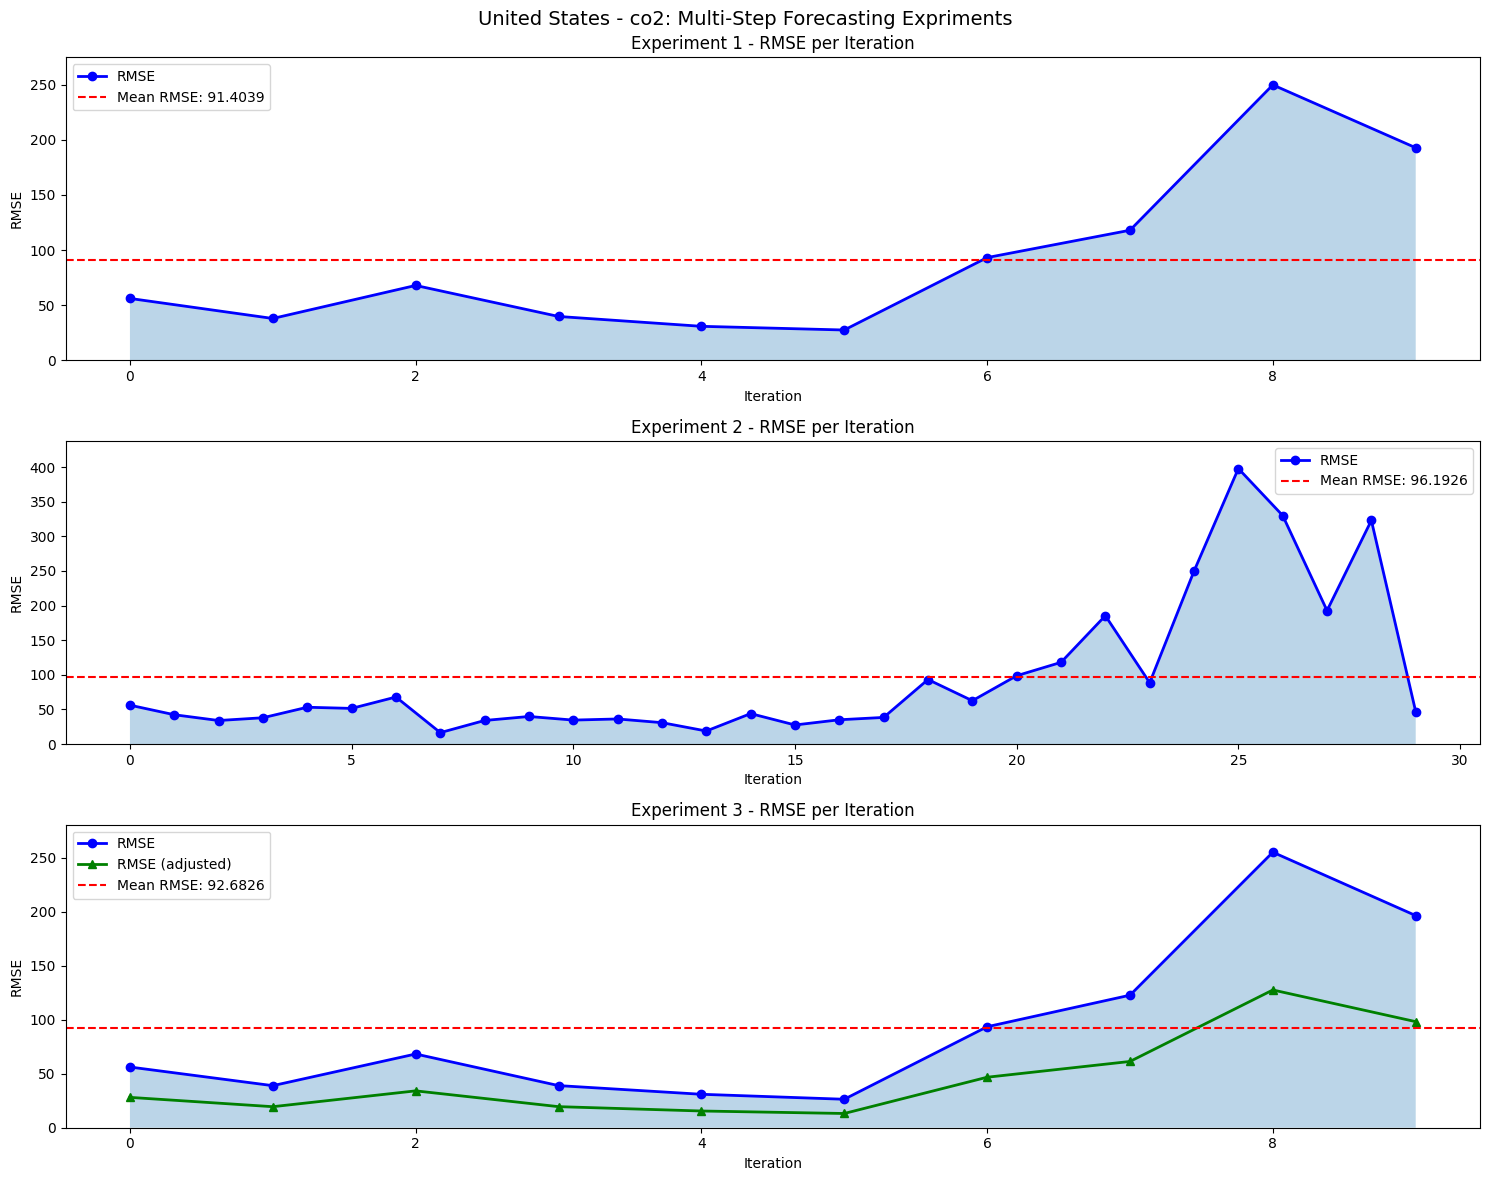


Debug - preds vs actuals


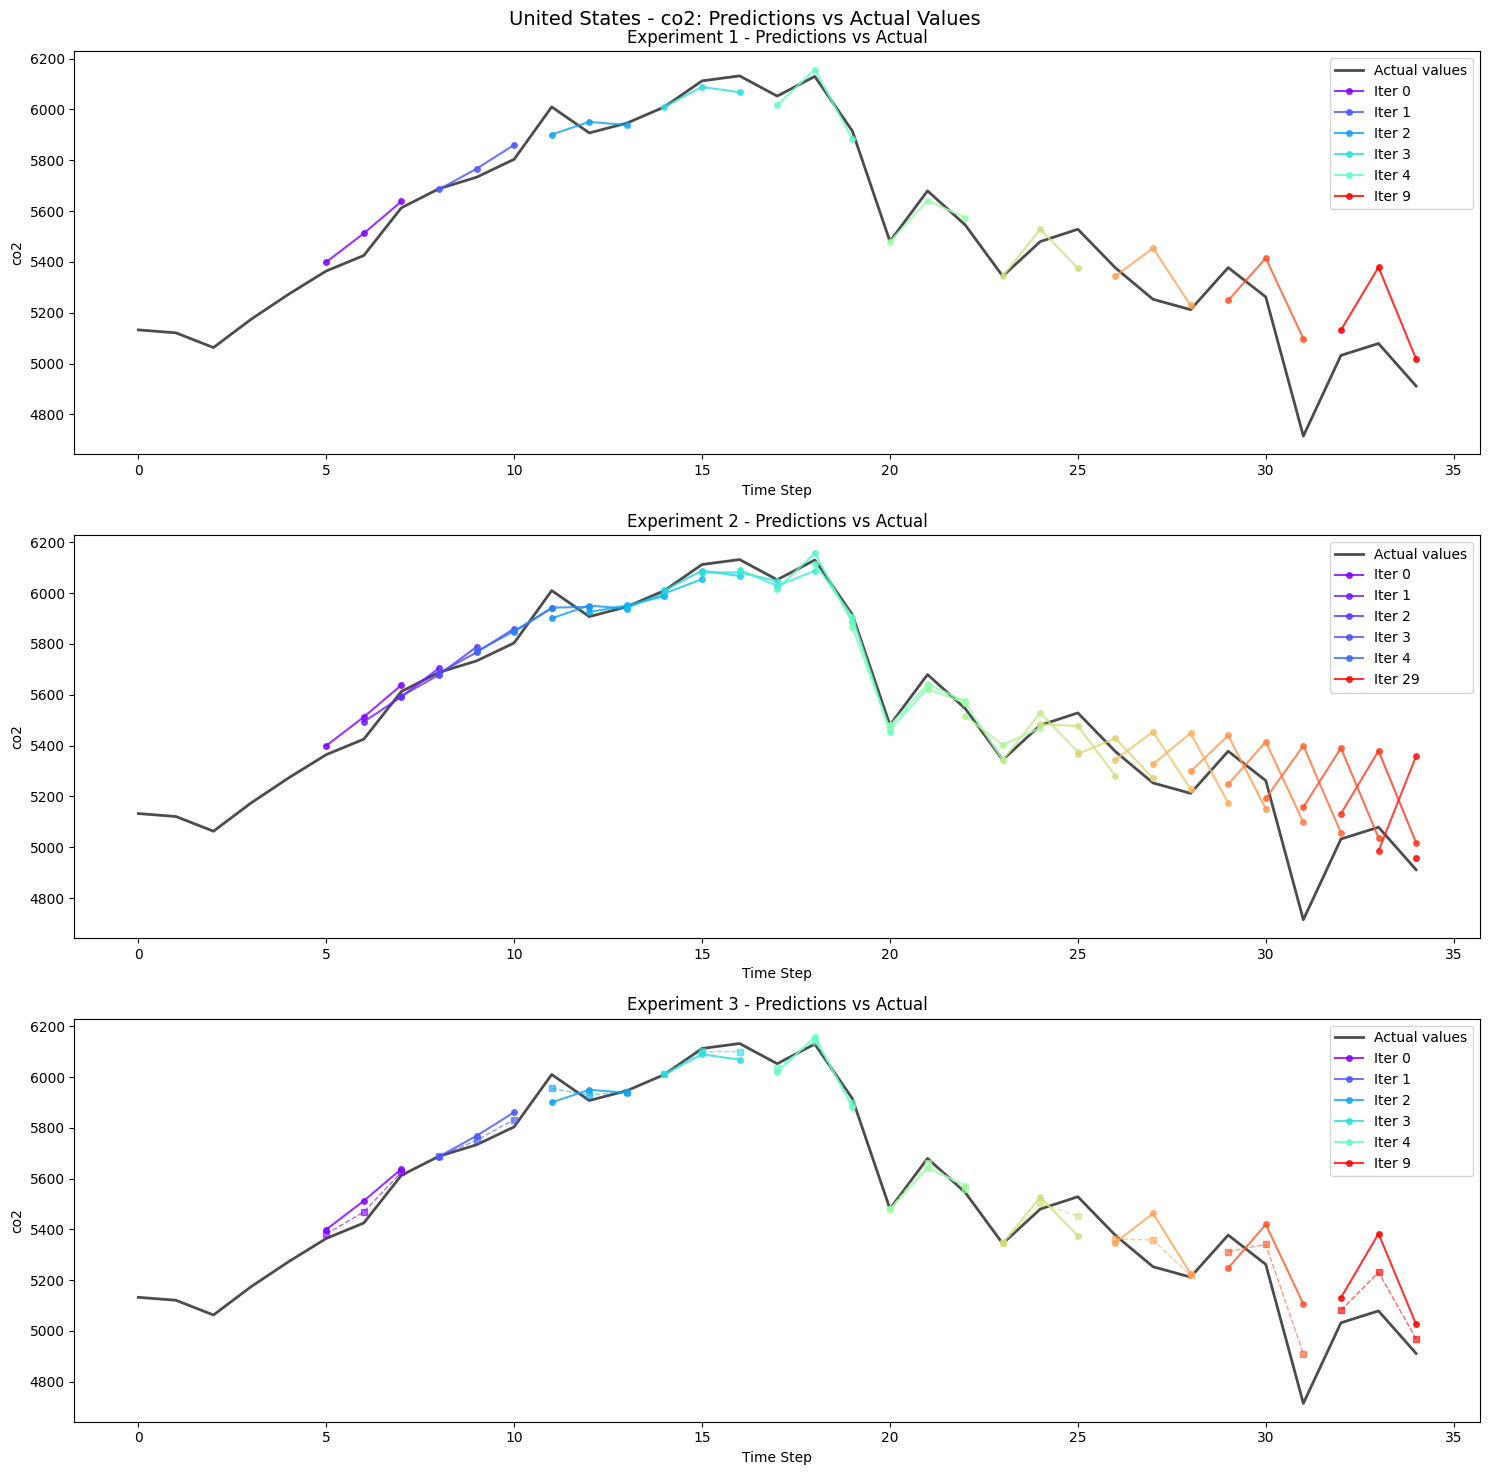

Saved detailed recursive results
Saved detailed recursive results
Saved detailed recursive results


In [130]:
results, comparison = run_multistep(
        country='United States',
        target='co2',
        model_func=build_lstm
    )


Running Multi step forecasting
Data Shape: (1138, 992)
Number of feature columns: 30
Feature columns ex 5: ['fossil_fuel_consumption', 'fossil_fuel_consumption_lag1', 'fossil_fuel_consumption_lag2', 'fossil_fuel_consumption_lag3', 'fossil_fuel_consumption_lag4']
X shape: (34, 30), y shape: (34,)
Data splits - Total: 34, Train: 24, Val: 5, Test: 5

Training model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 32)          │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,539 (21.64 KB)

 Trainable params: 5,539 (21.64 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 32)          │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,539 (21.64 KB)

 Trainable params: 5,539 (21.64 KB)

 Non-trainable params: 0 (0.00 B)


First Experiment: Sliding window by 3 steps (no overlapping)
Iteration 0: RMSE: 84220928848.4220
Iteration 1: RMSE: 179227579488.3115
Iteration 2: RMSE: 12164559928.2493
Iteration 3: RMSE: 79758280832.9617
Iteration 4: RMSE: 127604315394.3914
Iteration 5: RMSE: 186120397683.2177
Iteration 6: RMSE: 638495201809.4890
Iteration 7: RMSE: 1546373319425.4053
Iteration 8: RMSE: 1886436961709.7844
Iteration 9: RMSE: 1479270811842.9307
Total iterations: 10

Second Experiment: Sliding window by each step
Iteration 0: RMSE: 84220928848.4220
Iteration 5: RMSE: 47245819723.4591
Iteration 10: RMSE: 182710380014.3414
Iteration 15: RMSE: 186120397683.2177
Iteration 20: RMSE: 1272128017088.1406
Iteration 25: RMSE: 1677761449350.8401
Total iterations: 29

Third Experiment: Recursive Strategy
Iteration 0: RMSE: 84220928848.4220
Iteration 1: RMSE: 179161329162.2944
Iteration 2: RMSE: 19235163726.9281
Iteration 3: RMSE: 82900555817.4370
Iteration 4: RMSE: 125488103282.7789
Iteration 5: RMSE: 185410050658.

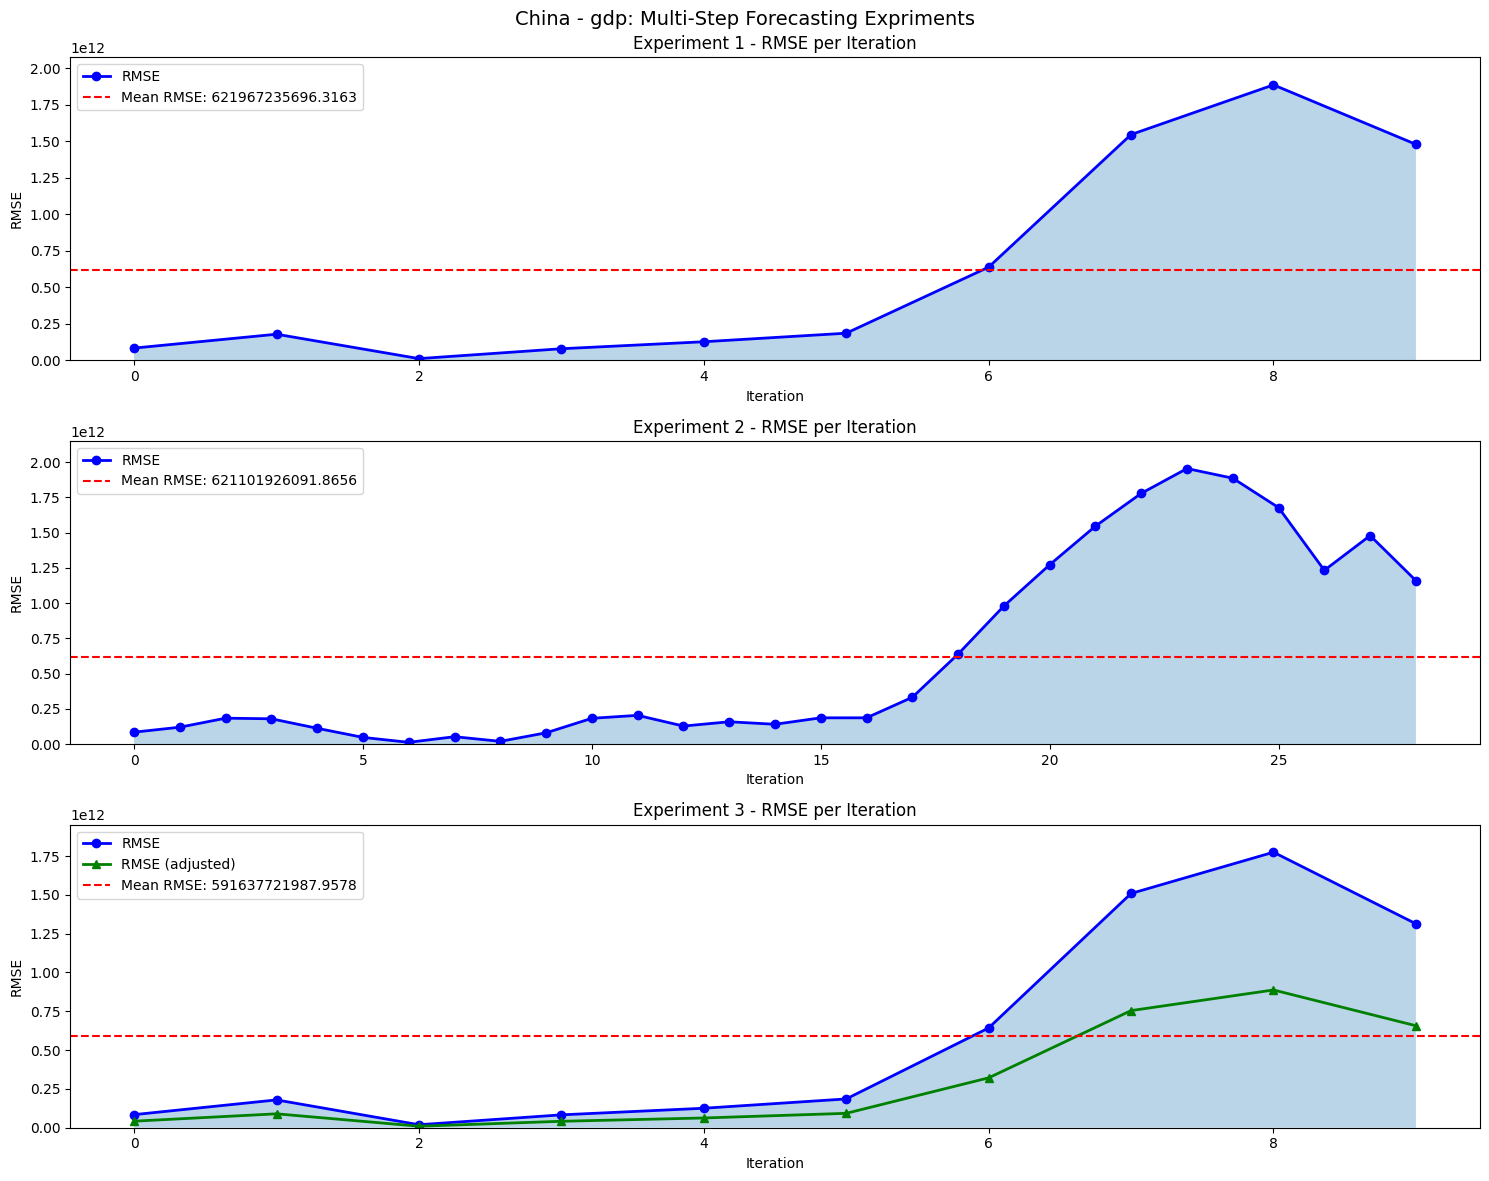


Debug - preds vs actuals


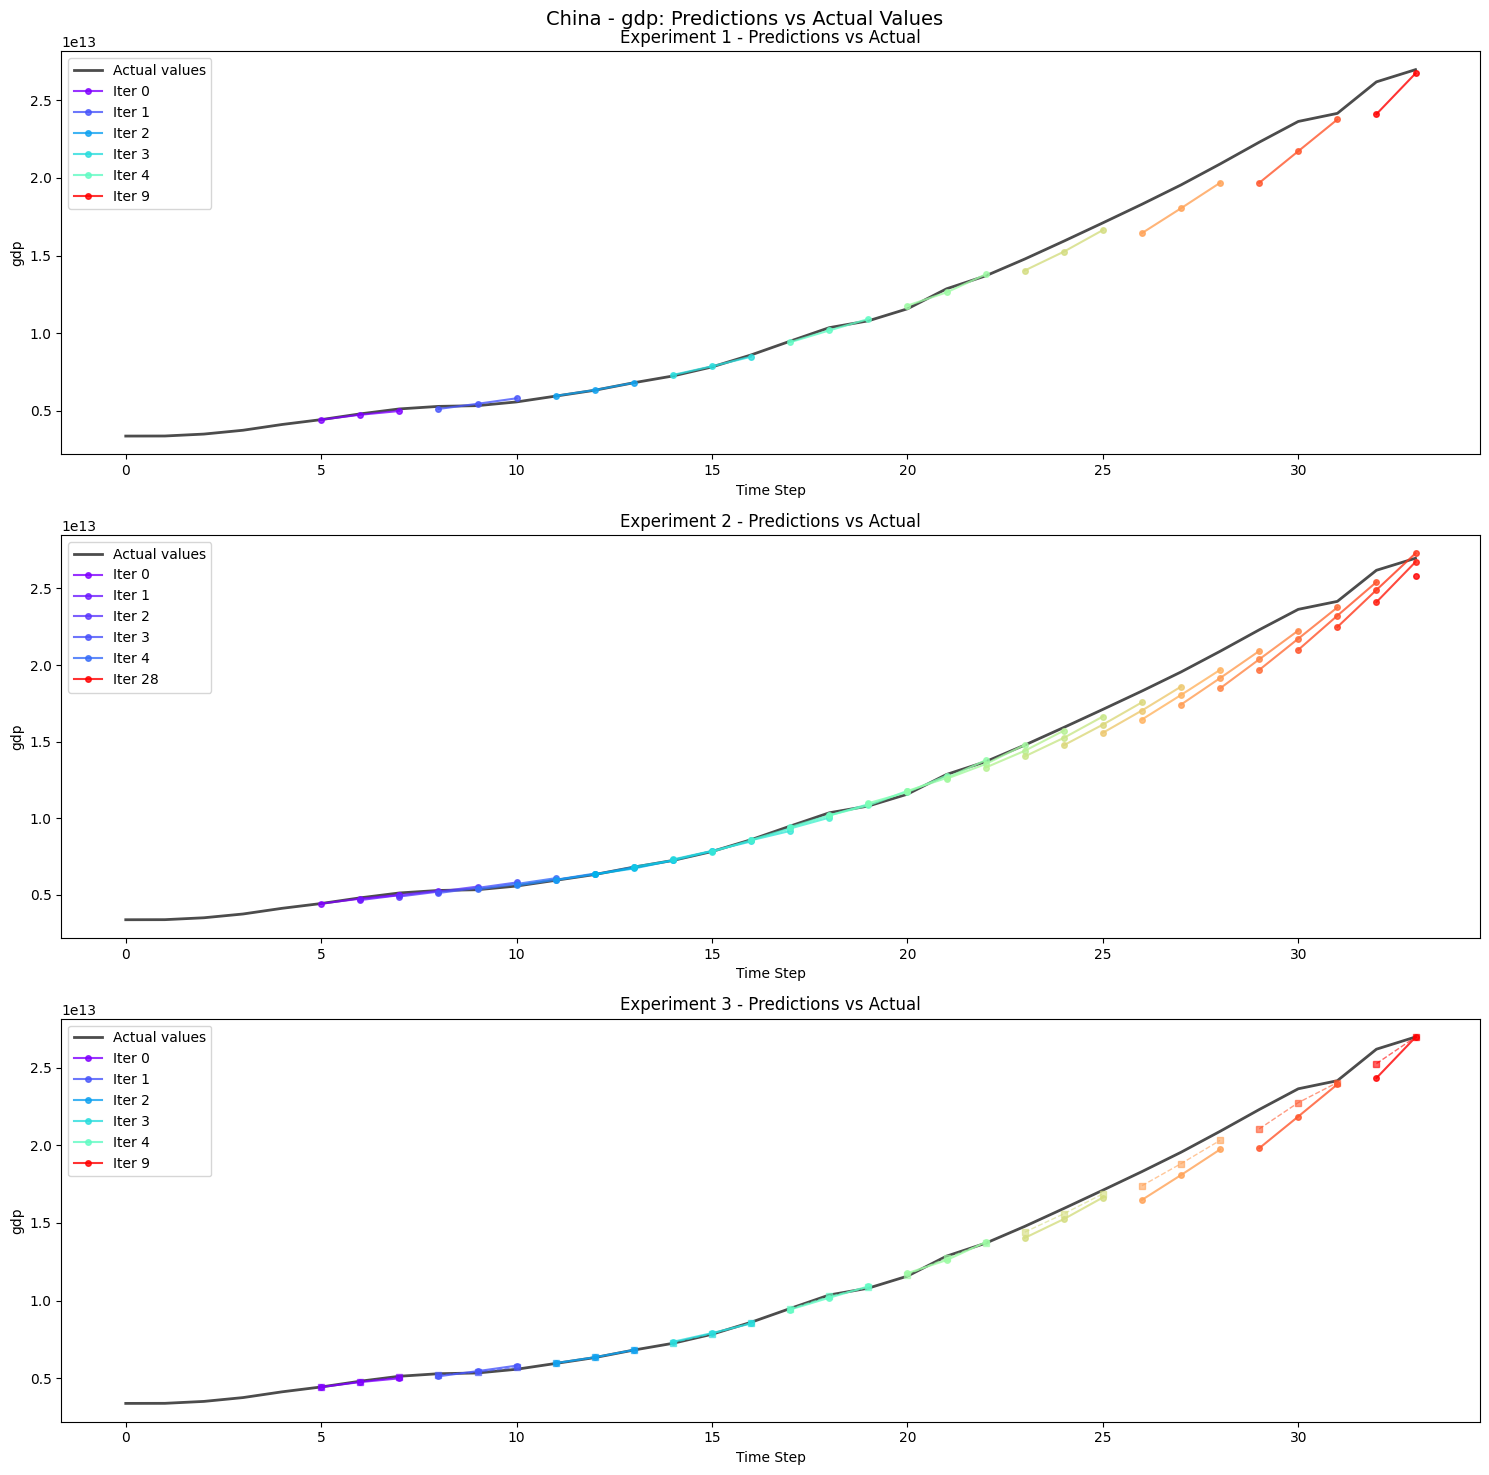

Saved detailed recursive results
Saved detailed recursive results
Saved detailed recursive results


In [131]:
results, comparison = run_multistep(
        country='China',
        target='gdp',
        model_func=build_cnn
    )


Running Multi step forecasting
Data Shape: (1138, 992)
Number of feature columns: 30
Feature columns ex 5: ['fossil_fuel_consumption', 'fossil_fuel_consumption_lag1', 'fossil_fuel_consumption_lag2', 'fossil_fuel_consumption_lag3', 'fossil_fuel_consumption_lag4']
X shape: (35, 30), y shape: (35,)
Data splits - Total: 35, Train: 25, Val: 5, Test: 5

Training model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 16)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 1)           │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,137 (20.07 KB)

 Trainable params: 5,137 (20.07 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 16)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 1)           │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,137 (20.07 KB)

 Trainable params: 5,137 (20.07 KB)

 Non-trainable params: 0 (0.00 B)


First Experiment: Sliding window by 3 steps (no overlapping)
Iteration 0: RMSE: 7.2159
Iteration 1: RMSE: 14.3715
Iteration 2: RMSE: 6.7078
Iteration 3: RMSE: 6.6607
Iteration 4: RMSE: 19.2553
Iteration 5: RMSE: 15.9270
Iteration 6: RMSE: 14.3894
Iteration 7: RMSE: 56.7572
Iteration 8: RMSE: 147.5917
Iteration 9: RMSE: 187.6283
Total iterations: 10

Second Experiment: Sliding window by each step
Iteration 0: RMSE: 7.2159
Iteration 5: RMSE: 12.3073
Iteration 10: RMSE: 18.7186
Iteration 15: RMSE: 15.9270
Iteration 20: RMSE: 40.5417
Iteration 25: RMSE: 155.3834
Total iterations: 30

Third Experiment: Recursive Strategy
Iteration 0: RMSE: 7.2159
Iteration 1: RMSE: 14.3809
Iteration 2: RMSE: 6.6842
Iteration 3: RMSE: 6.6511
Iteration 4: RMSE: 19.3188
Iteration 5: RMSE: 15.9283
Iteration 6: RMSE: 14.3614
Iteration 7: RMSE: 56.6343
Iteration 8: RMSE: 147.4471
Iteration 9: RMSE: 187.5065
Total iterations: 10

Expoeriment comparison

Experiment_1
    Iteration: 10
    Mean RMSE: 47.6505
    Mi

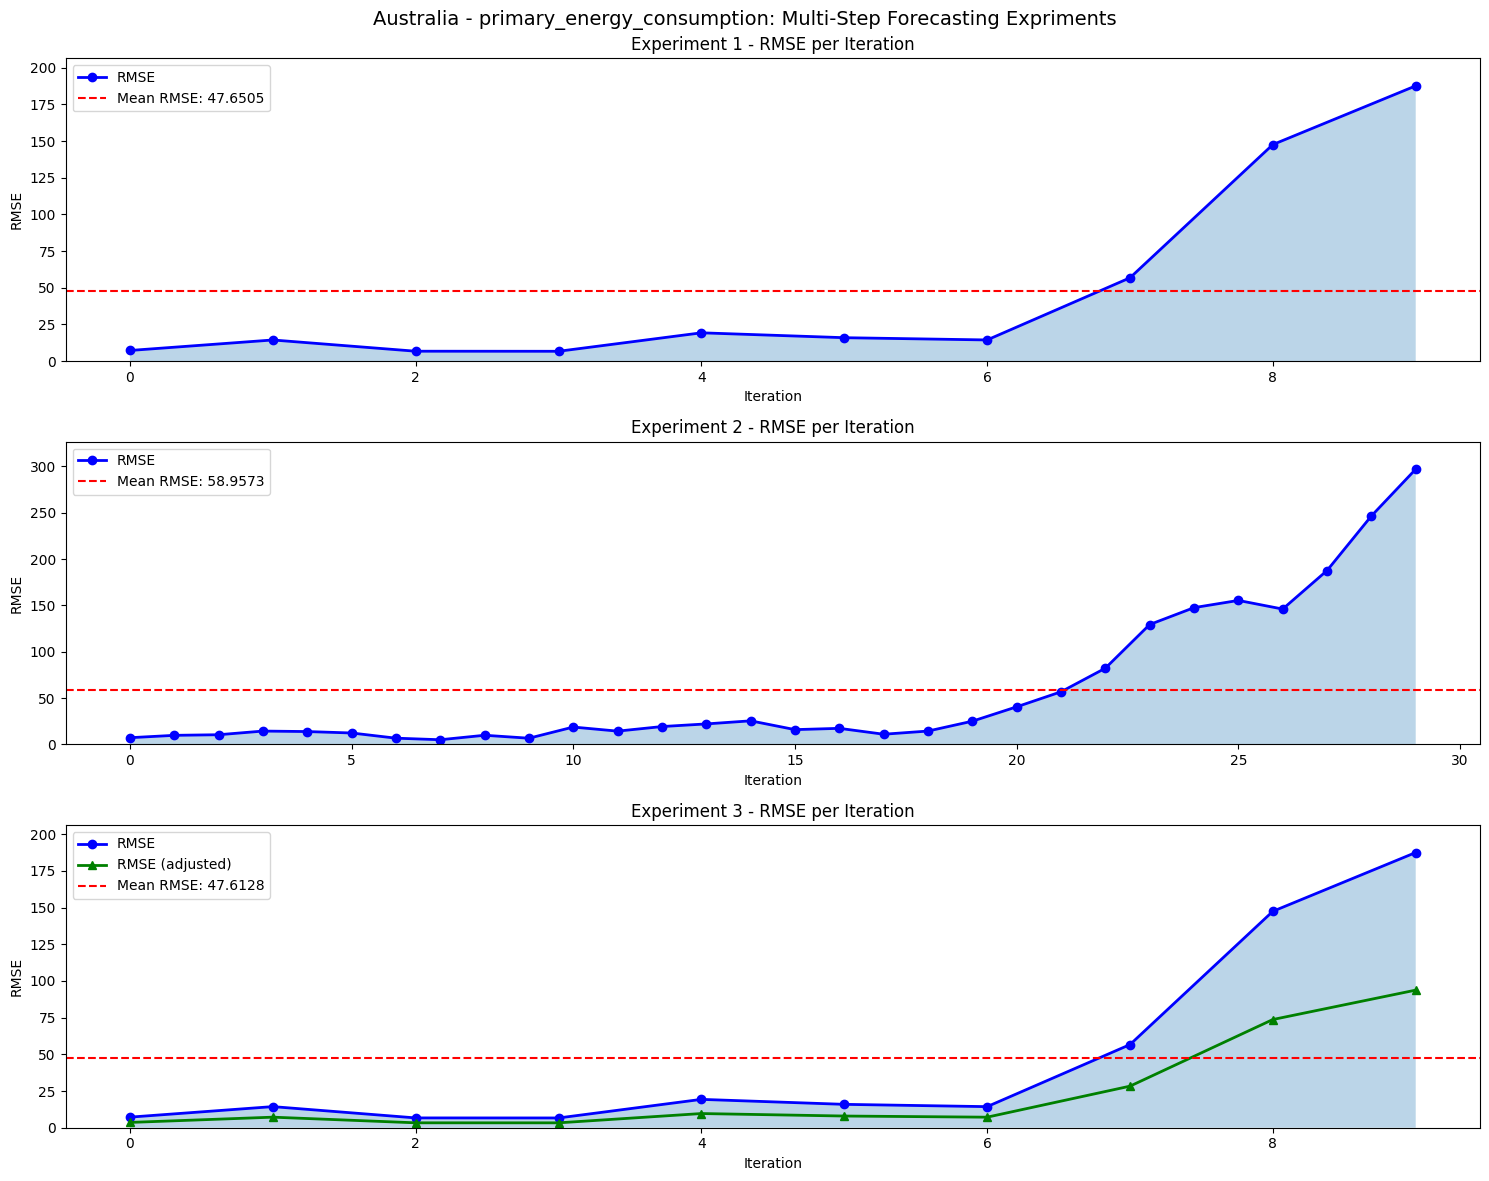


Debug - preds vs actuals


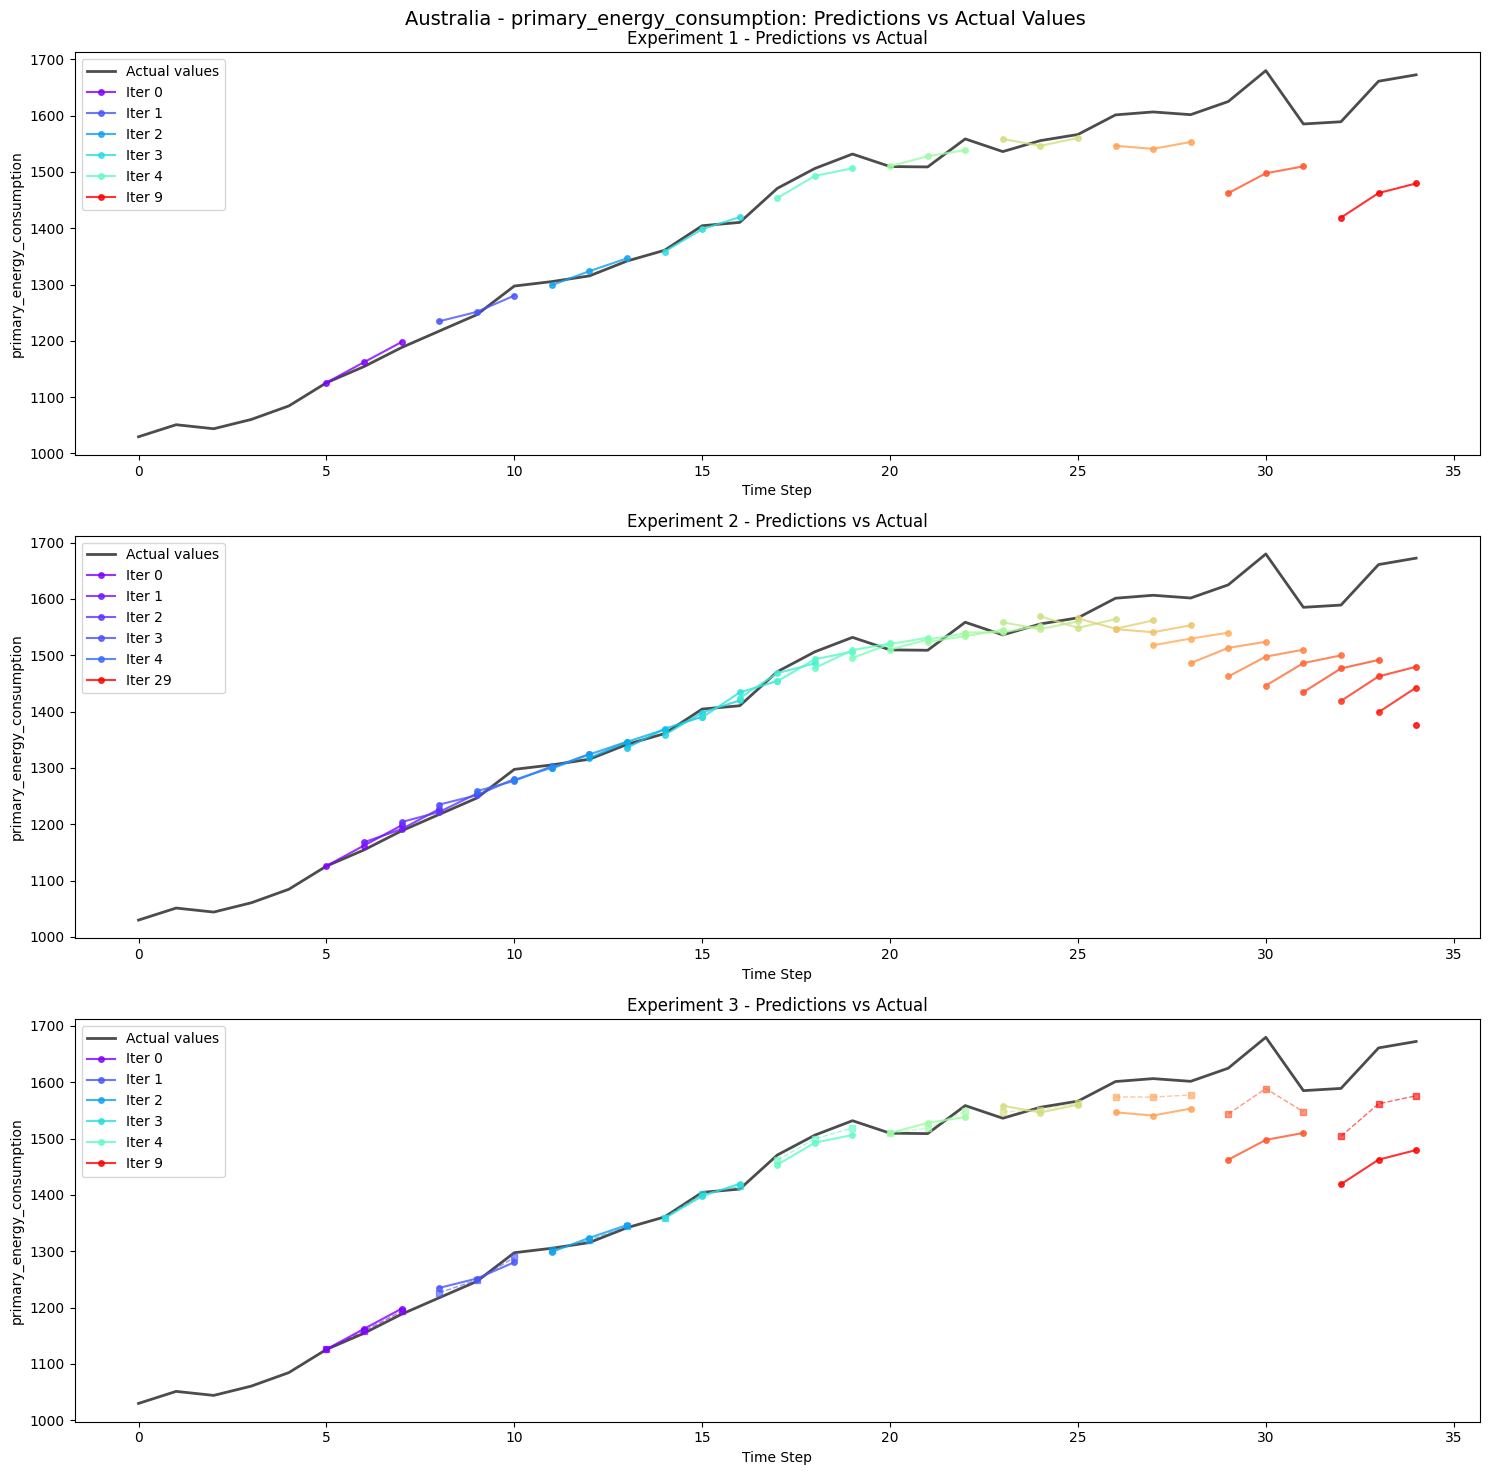

Saved detailed recursive results
Saved detailed recursive results
Saved detailed recursive results


In [135]:
results, comparison = run_multistep(
        country='Australia',
        target='primary_energy_consumption',
        model_func=build_edlstm
    )